In [1]:
import pandas as pd
import warnings
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [2]:
df_industries = pd.read_excel('./data/Exam-Industry.xlsx', index_col='Date')
df_market = pd.read_excel('./data/Exam–Market.xlsx', index_col='Date')
df = pd.merge(df_industries, df_market, left_index=True, right_index=True)
# df_risk_factors = pd.read_excel('./data/Risk_Factors.xlsx', index_col='Date')

Hansen–Jagannathan Bound

Suppose that the representative investor has constant absolute risk aversion, which gives rise to the following pricing kernel:
$$
\tilde{M} = 0.99 e^{b_0(1-\tilde{g})}
$$

Here b0 is the investor's coefficient of relative risk aversion, based on initial consumption.

Suppose that consumption growth has lognormal distribution with rare disasters:


Here ε is a standard normal random variable, while η is an independent random variable that represents the effect of rare disasters: η = ln(0.7) with probability of 2.4%, or zero otherwise.

Simulate the distribution for consumption growth with (at least) 104 random draws for ε and η. Calculate the volatility ratio of the pricing kernel, for b0 in the range from 0 to 5, in increments of 0.1 (or less). Plot the volatility ratio vs b0.



In [3]:
def estimate_pricing_kernel(size: int, p_nu: float, phi: float, b0: float)-> tuple:
    """
    Estimates the pricing kernel statistics: mean, standard deviation, and ratio of std dev to mean.
    
    Parameters:
        size (int): Number of samples to generate.
        p_nu (float): Probability of shock occurrence (`nu`).
        phi (float): Scaling parameter for shock impact.
        gamma (float): Risk aversion parameter.

    Returns:
        mean_M (mean of pricing kernel), 
        sig_M (standard deviation of pricing kernel), 
        sig_M_over_mean_M (ratio of std dev to mean).
    """
    epsilon = np.random.standard_normal(size)
    nu = np.random.choice([1,0], size=size, p=[p_nu,1-p_nu]) * np.log(phi)


    ln_g = .02 + .02 * epsilon + nu
    est_M = 0.99*np.exp(b0*(1-(np.exp(ln_g))))

    mean_M = np.mean(est_M)
    sig_M = np.std(est_M)
    sig_M_over_mean_M = sig_M / mean_M

    return mean_M, sig_M, sig_M_over_mean_M

In [4]:
size        = 10**5
p_nu        = .024
phi         = .7
arr_b0   = np.linspace(1,5,500)

# Generate results for gamma values from 1 to 5
results_df = pd.DataFrame(columns=['b0', 'Mean_M', 'Sig_M', 'Sig_M_over_Mean_M'])

for b0 in arr_b0:
    mean_M, sig_M, sig_M_over_mean_M = estimate_pricing_kernel(size, p_nu, phi, b0)
    # Create a temporary DataFrame for the current result
    temp_df = pd.DataFrame({
        'b0': [b0],
        'Mean_M': [mean_M],
        'Sig_M': [sig_M],
        'Sig_M_over_Mean_M': [sig_M_over_mean_M]
    })
    # Concatenate the temporary DataFrame to results_df
    results_df = pd.concat([results_df, temp_df], ignore_index=True)


/var/folders/h2/r7qn2m9n1zb6y_0q191gdqth0000gn/T/ipykernel_32654/3255038618.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


Find and report the smallest value of b0 for which the Hansen–Jagannathan bound is satisfied, in your data set.


The smallest value of gamma for which sig_M/mu_M > 0.4 is: 4.278557114228457


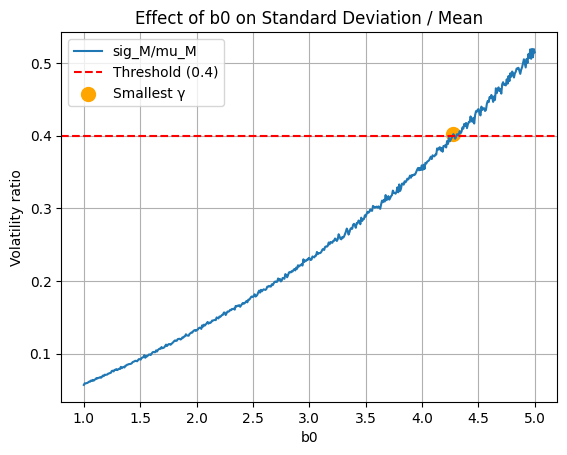

In [5]:
# Find the smallest gamma where Sig_M_over_Mean_M > 0.4
threshold = 0.4
condition_met = results_df[results_df['Sig_M_over_Mean_M'] > threshold]
smallest_b0 = condition_met['b0'].iloc[0] if not condition_met.empty else None

# Display the smallest gamma
print(f"The smallest value of gamma for which sig_M/mu_M > 0.4 is: {smallest_b0}")

# Plotting the last output against gamma
plt.plot(results_df['b0'], results_df['Sig_M_over_Mean_M'], label='sig_M/mu_M')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold (0.4)')
if smallest_b0 is not None:
    plt.scatter(smallest_b0, results_df['Sig_M_over_Mean_M'].iloc[condition_met.index[0]], color='orange', s=100, label='Smallest γ')
plt.xlabel('b0')
plt.ylabel('Volatility ratio')
plt.title('Effect of b0 on Standard Deviation / Mean')
plt.legend()
plt.grid()
plt.show()

In [6]:
def exp_sample_v_xg(x: float, g: np.array, lambd: float) -> np.ndarray:
    """
    function to expected for a sample of random consumption growth v(xg) 
    Parameters:
        x (int or float): Input value for x which is 1 + D/P or one period return
        g (np.ndarray): Array of values for g, sample consumption growth (monte carlo)
        lambd (float): Lambda parameter for loss aversion multiplier
    return
        estimate of  v_xg as numpy array
    """
    xg = x * g

    return np.array([lambd * (R - R_f) if R < R_f else (R - R_f) for R in xg]).mean()

def e(x, g, lambd, b0)-> float:
    """
    Function to calculate error, e(x) based on the equilibrium condition for the price-dividend ratio of the market portfolio.
    
    Parameters:
        x (int or float):  x which is 1 + D/P or one period return
        g (np.ndarray): Array representing g, sample consumption growth (monte carlo)
        lambd (float): Lambda parameter for loss aversion multiplier
        b0 (float): This scaling factor adjusts the relative importance of financial gain/loss utility compared to consumption utility.

    Returns:
        float: Calculated error term e(x) as a floating-point number.
    """
    # TODO MAKE SURE TO CHANGE ERROR TERM EXPRESSION ACCORDINGLY
    return 0.99 * b0 * exp_sample_v_xg(x, g, lambd) + 0.99 * x - 1

def bisection_search(func, x_low: float, x_high: float, iter: int, tol: float) -> tuple:
    """
    Performs the bisection search method to find a root of the function `func`.
    
    Parameters:
        func (Callable[[float], float]): The function for which the root is sought.
        x_low (float): The initial lower bound.
        x_high (float): The initial upper bound.
        iter (int): Maximum number of iterations.
        tol (float): Tolerance level for convergence.

    Returns:
        Optional[Tuple[float, int]]: The root approximation and iteration count if found within tolerance, else `None`.
    """
    for i in range(iter):
        x_0 = 0.5 * (x_low + x_high)
        e_0 = func(x_0)

        if abs(e_0) < tol:
            return x_0, i
        elif e_0 < 0:
            x_low = x_0
        else:
            x_high = x_0
    
    return None

---

# State Prices

State Prices

You must show all relevant working for these results.

Suppose that a one-period financial market has two states of nature: "good" and "bad".

This financial market has two assets: stock A and stock B. Both stocks have initial price of 70 (per share), and the following distribution of final payoffs (per share):

 	Good	Bad
Stock A	100	50
Stock B	80	65
Calculate the initial prices for the elementary Arrow–Debreu securities.

Calculate the risk-neutral probabilities for the two states.
Consider a financial derivative with final payoff given by Y = max[XA, XB] – 55, where XA and XB are the final payoffs for one share of stock A and stock B, respectively.

Calculate the initial price for this financial derivative.

Calculate the amount to invest in the two stocks, in order to replicate this financial derivative.

>LetP=[P1,...,Pk]′ bek×1vectorofinitialpricesforone share of each asset: to avoid arbitrage, portfolio with final payoffs of Y must have initial price of P_Y = P′N = P′X−1Y

If you assume there is a financial contract that pays 1 for good state, and that contract costs p_goodthen \
p_good = (cost of contract) / (payout in good state)  = p_good / 1 \
and\
p_bad = (cost of contract) / (payout in bad state)  = p_bad / 1 

so consider a security that pays 100 in good and 50 in bad. we can construct it with multiple elementary contracts \
p_security =\
 (total cost of elementary securities) = \
  (security payout in good outcome) X (cost of contract / payout 1 in case of good outcome) \
 \+ (security payout in bad outcome) X (cost of contract / payout 1 in case of bad outcome)

In [7]:
df = pd.DataFrame({
    "Stock A":  [100, 50],
    "Stock B":  [80, 65]
})

since \
70 = 100 * p_good + 50 * p_bad\
70 = 80  * p_good + 65 * p_bad

Solve above as simultaneous equations

In [8]:
X = df.values.T
P = np.array([70, 70])
state_prices = np.linalg.inv(X)@P.T

print("state prices good and bad respectively")
state_prices

state prices good and bad respectively


array([0.42, 0.56])

$$\hat{\pi}_{s} = R_f p_s = R_f M_s \pi_s = \left(\frac{M_s}{E[\tilde{M}]}\right) \pi_s$$

We need to find R_f so we will use below formulas
$$[\hat{\pi}_u \quad \hat{\pi}_d] = R_f [p_u \quad p_d] = \left[\frac{R_f - d}{u - d} \quad \frac{u - R_f}{u - d}\right]$$

In [9]:
X

array([[100,  50],
       [ 80,  65]])

In [10]:
X_1 = np.array([[100, 80],
                [50, 65]])

P.T@np.linalg.inv(X_1)

array([0.42, 0.56])

Risk Neutral probabilities sum to 1 \
$$ \hat{\pi}_u + \hat{\pi}_d = R_f(p_u + p_d)  = 1$$
and the state prices are scaled by the same constant to get the Risk Neutral probabilities so the state prices and Risk Neutral probabilities are similar

In [11]:
R_f = 1/np.sum(state_prices)
R_f

1.020408163265306

In [12]:
risk_neut_probs = R_f*state_prices
print(f"Risk Neutral Probabilities [u, d]: {risk_neut_probs}")

Risk Neutral Probabilities [u, d]: [0.42857143 0.57142857]


Consider two end states, bad and good

Good:\
Y_good = max[100, 80] - 55 = 45

Bad:\
Y_bad = max[50, 65] - 55 = 10


initial price of call option:\
(state payoff_good X state price_good) + (state payoff_bad X state price_bad)\
Alternatively,\
[(state payoff_good X risk neutral probability_good) + (state payoff_bad X risk neutral probability_bad)] / R_f

In [13]:
# Method 1
call_1 = np.array([45, 10]) @ state_prices
# Method 2
call_2 = np.array([45, 10]) @ risk_neut_probs / R_f

print(f"Initial price for financial derivative ${call_1:.2f}")
call_1, call_2

Initial price for financial derivative $24.50


(24.50000000000001, 24.50000000000001)

In [14]:
N = np.linalg.inv(X)@np.array([45, 10])
print(f"vector of required shares in each asset [A, B] to replicate security: {N}")

vector of required shares in each asset [A, B] to replicate security: [ 0.97 -1.04]


In [15]:
# Verify they pay off of the amounts
X@N

array([45., 10.])

In [16]:
N * P

array([ 67.9, -72.8])